In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.plotters as skplt

import nltk

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras import regularizers
from keras.constraints import max_norm, unit_norm


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/"))

# Any results you write to the current directory are saved as output.

['stage2_test_variants.csv', 'test_text', 'stage1_solution_filtered.csv', 'training_variants', 'training_text', 'stage2_sample_submission.csv', 'stage2_test_text.csv', 'test_variants', 'submissionFile']


In [49]:
train_variants = pd.read_csv("../input/training_variants")
train_variants.head(8)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1


In [50]:
test_variants = pd.read_csv("../input/test_variants")
test_variants.head(8)


,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A
5,5,CD40LG,A123E
6,6,KLF11,T220M
7,7,SGCB,T151R


In [51]:
train_text = pd.read_csv("../input/training_text", 
                         sep="\|\|", 
                         engine='python', 
                         header=None, 
                         skiprows=1, 
                         names=["ID","Text"])
test_text = pd.read_csv("../input/test_text", 
                        sep="\|\|", 
                        engine='python', 
                        header=None, 
                        skiprows=1, 
                        names=["ID","Text"])
print("Train variants shape : ",train_variants.shape)
print("test variants shape : ",test_variants.shape)
print("Train text shape : ",train_text.shape)
print("test text shape : ",test_text.shape)

Train variants shape :  (3321, 4)
test variants shape :  (5668, 3)
Train text shape :  (3321, 2)
test text shape :  (5668, 2)


In [52]:
# i am interested to read a whole text in a single row of train text file!!!
counter = 0
with open("../input/training_text", encoding="utf8") as infile:
    while True:
        counter += 1
        line = infile.readline()
        print(line)
        if counter==2:
            break


ID,Text

0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

In [53]:
# lets see the length of each Text row
train_text['word_count'] = train_text['Text'].apply(lambda x: len(str(x).split(" ")))
train_text[['ID','Text','word_count']].head()

,ID,Text,word_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6105
1,1,Abstract Background Non-small cell lung canc...,5783
2,2,Abstract Background Non-small cell lung canc...,5783
3,3,Recent evidence has demonstrated that acquired...,5625
4,4,Oncogenic mutations in the monomeric Casitas B...,6248


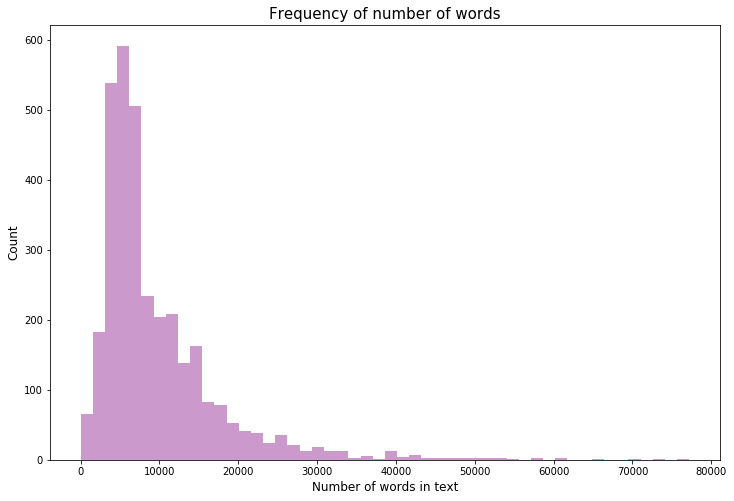

In [54]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text.word_count.values, bins=50, kde=False, color='purple')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

2 26.89
5 53.03
10 71.59
20 82.95
20 82.95
50 95.08
100 98.11
300 100.0


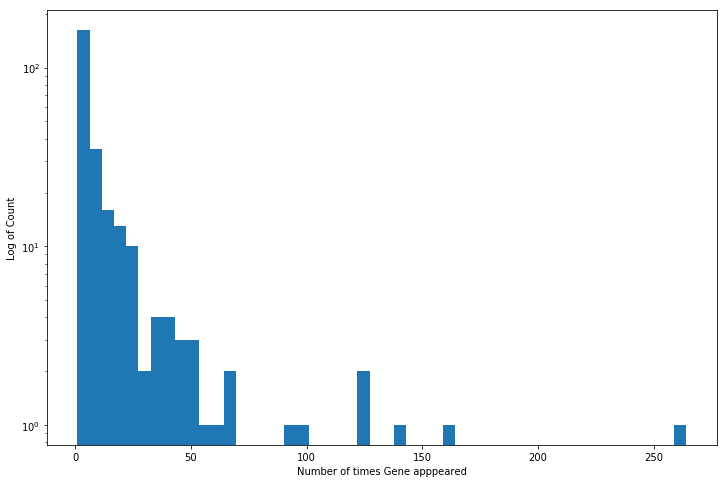

In [55]:
train_genes = train_variants.groupby('Gene')['Gene'].count()

for i in [2,5,10,20,20,50,100,300]:
    print(i, round((train_genes < i).mean()*100, 2))

plt.figure(figsize=(12,8))
plt.hist(train_genes.values, bins = 50, log = True)
plt.xlabel('Number of times Gene apppeared')
plt.ylabel('Log of Count')
plt.show()

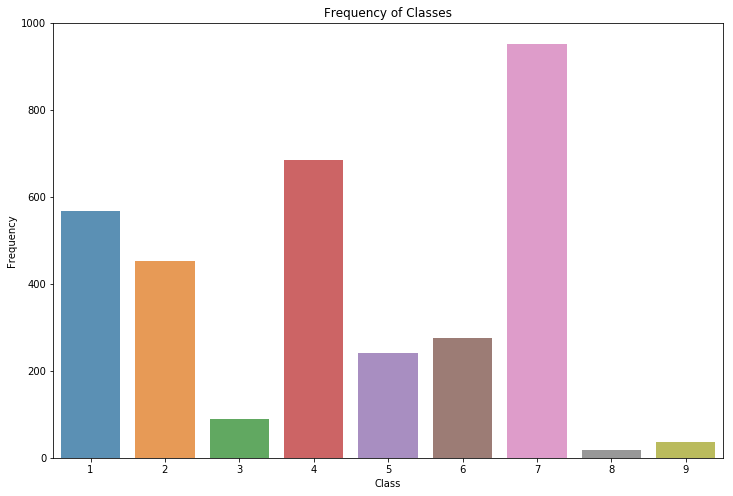

In [56]:

class_df = train_variants.Class.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(class_df.index, class_df.values, alpha=0.8)
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title('Frequency of Classes')
plt.show()

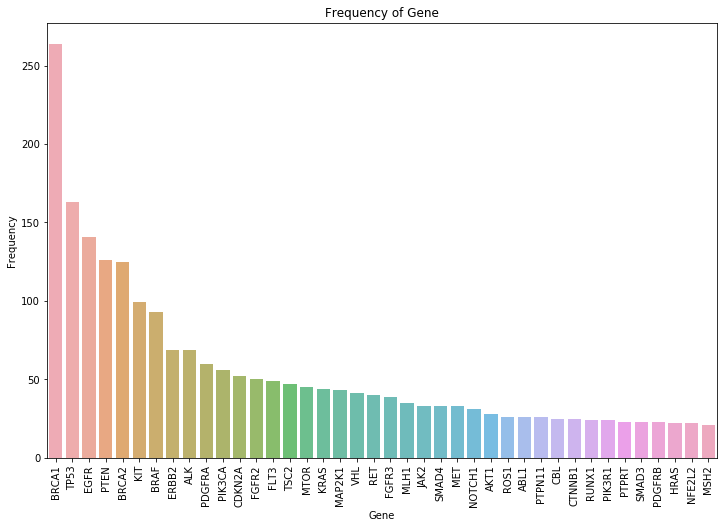

In [57]:
gene_df = train_variants.Gene.value_counts()
gene_df = gene_df.head(40)
plt.figure(figsize=(12,8))
sns.barplot(gene_df.index, gene_df.values, alpha=0.8)

plt.ylabel('Frequency')
plt.xlabel('Gene')
plt.title('Frequency of Gene')
plt.xticks(rotation='vertical')
plt.show()

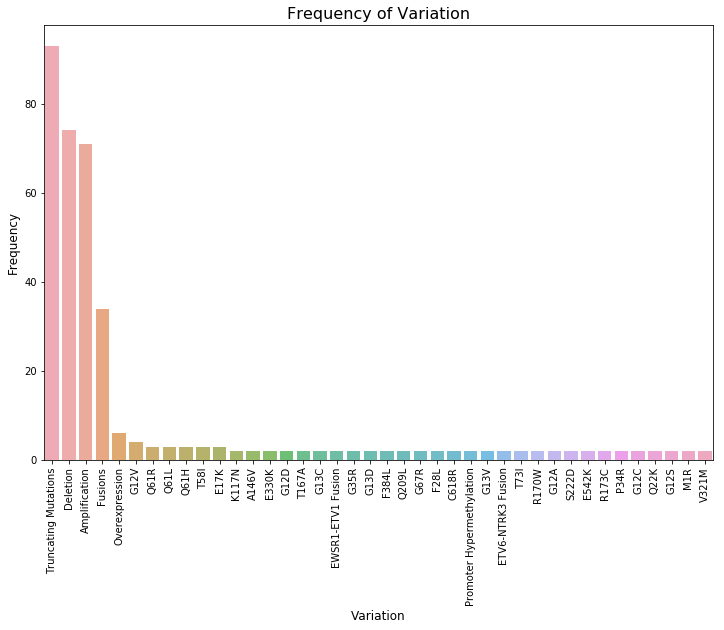

In [58]:
Var_df = train_variants.Variation.value_counts().reset_index()
Var_df = Var_df.head(40)
plt.figure(figsize = (12,8))
sns.barplot(Var_df['index'], Var_df.Variation, alpha=0.8)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Variation', fontsize = 12)
plt.title('Frequency of Variation', fontsize = 16)
plt.xticks(rotation='vertical')
plt.show()

In [59]:
train_variants.ID = train_variants.ID.astype(str)
test_variants.ID = test_variants.ID.astype(str)
train_text.ID = train_text.ID.astype(str)
test_text.ID = test_text.ID.astype(str)

train_full = pd.merge(train_variants, train_text, on='ID')
test_full  = pd.merge(test_variants, test_text, on='ID')

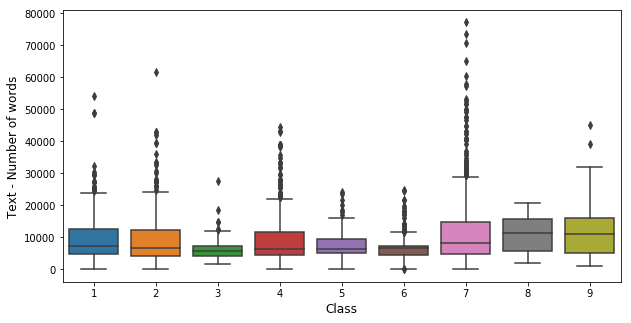

In [60]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Class', y='word_count', data=train_full)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


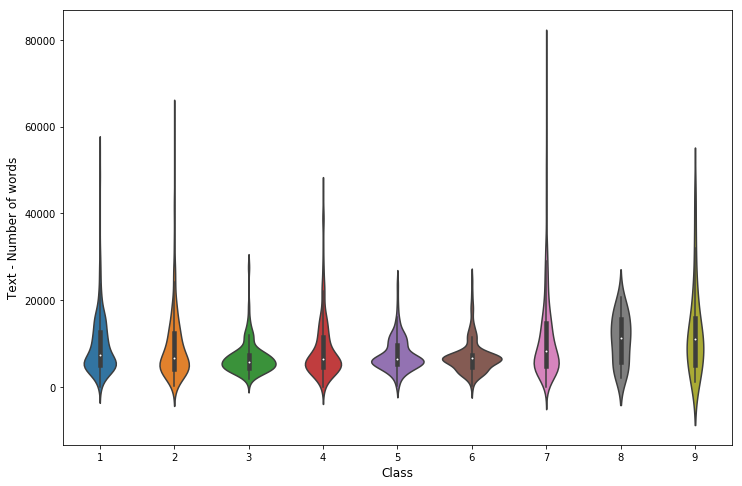

In [61]:
plt.figure(figsize=(12,8))
sns.violinplot(x='Class', y='word_count', data=train_full)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

In [62]:
train_full.describe(include='all')

,ID,Gene,Variation,Class,Text,word_count
count,3321,3321,3321,3321.000000,3316,3321.000000
unique,3321,264,2996,NaN,1920,NaN
top,1980,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...,NaN
freq,1,264,93,NaN,53,NaN
mean,NaN,NaN,NaN,4.365854,NaN,9574.389642
std,NaN,NaN,NaN,2.309781,NaN,7890.969431
min,NaN,NaN,NaN,1.000000,NaN,1.000000
25%,NaN,NaN,NaN,2.000000,NaN,4757.000000
50%,NaN,NaN,NaN,4.000000,NaN,6708.000000
75%,NaN,NaN,NaN,7.000000,NaN,12031.000000


In [63]:
test_full.describe(include='all')

,ID,Gene,Variation,Text
count,5668,5668,5668,5667
unique,5668,1397,5628,5610
top,1980,F8,Truncating Mutations,Mutations in BRCA1 and BRCA2 account for the m...
freq,1,134,18,6


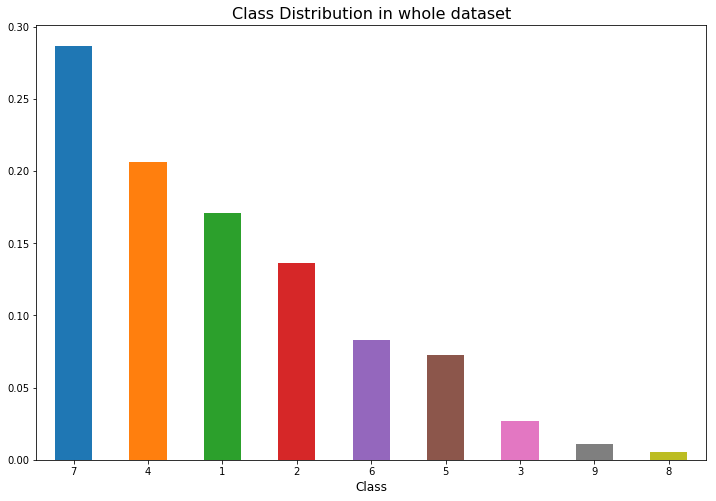

In [64]:
plt.figure(figsize=(12,8))
train_full['Class'].value_counts(normalize = True).plot(kind="bar", rot=0)
plt.xlabel('Class', fontsize=12)
plt.title('Class Distribution in whole dataset', fontsize = 16)
plt.show()

In [65]:
# This cell reduces the training data for Kaggle limits. Remove this cell for real results.
train_full, _ = train_test_split(train_full, test_size=0.7, random_state=8, stratify=train_full['Class'])
train_full.shape
train_full.head()

,ID,Gene,Variation,Class,Text,word_count
1791,1791,AR,W742L,7,Most prostate cancers (PCs) become resistant t...,4170
1865,1865,MTOR,R2505Q,3,Genes encoding components of the PI3K-Akt-mTOR...,4326
2278,2278,BCOR,BCOR-CCNB3 Fusion,8,he identification of subtype-specific transloc...,5489
2260,2260,PTEN,M35R,4,The PTEN (phosphatase and tensin homolog) phos...,6375
1564,1564,ALK,D1349H,5,"In the era of personalized medicine, understan...",6818


In [66]:
#Define a helper function to evaluate the effectiveness of transformed free text. 
#We'll use a simple logistic regression 
#with 3-fold stratified cross-validation for fast evaluation.
def feature_eval(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 0.3445622515404759
Accuracy: 0.9466666666666667


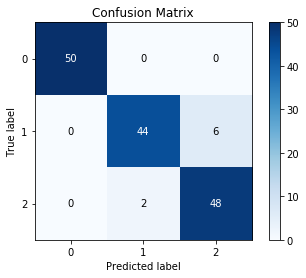

In [67]:
# Quick test of evaluate_features
from sklearn.datasets import load_iris
feature_eval(*load_iris(True))

In [68]:
## Start with a simple baseline. Bag of words
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)

In [69]:
words_bag = count_vectorizer.fit_transform(train_full['Text'])

In [70]:
len(count_vectorizer.get_feature_names())

157768

In [71]:
svd = TruncatedSVD(n_components=25, 
                   n_iter=25, 
                   random_state=12)
truncated_bag_of_words = svd.fit_transform(words_bag)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.6545325258841574
Accuracy: 0.4819277108433735


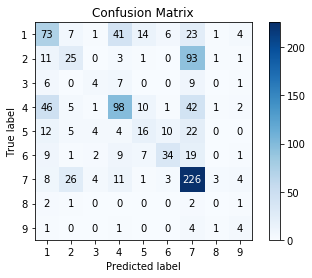

In [72]:
feature_eval(truncated_bag_of_words, train_full['Class'].values.ravel())

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.4417314777135375
Accuracy: 0.5050200803212851


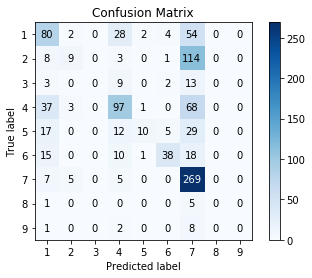

In [73]:
feature_eval(truncated_bag_of_words, train_full['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

In [74]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(train_full['Text'])

len(count_vectorizer.get_feature_names())

157768

In [75]:
svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.5090307759704997
Accuracy: 0.463855421686747


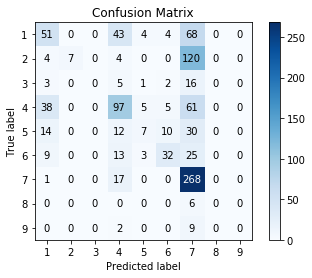

In [76]:
feature_eval(truncated_tfidf, train_full['Class'].values.ravel())

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.352922214289727
Accuracy: 0.5130522088353414


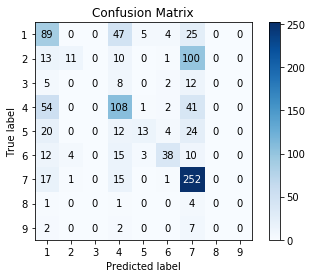

In [77]:
feature_eval(truncated_tfidf, train_full['Class'].values.ravel(), 
                  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.2054955766216386
Accuracy: 0.5502008032128514


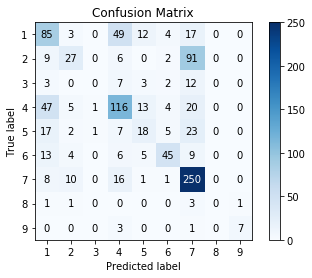

In [78]:
feature_eval(tfidf, train_full['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 10.0min finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.2339493469615657
Accuracy: 0.5692771084337349


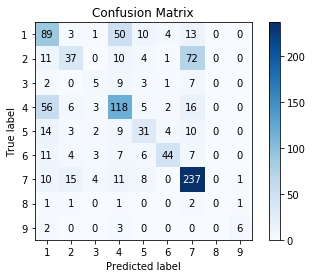

In [100]:
feature_eval(tfidf, 
                  train_full['Class'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

In [ ]:
#word2vec

In [94]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [95]:
w2vec = get_word2vec(
    MySentences(
        train_full['Text'].values, 
        #df_test['Text'].values  Commented for Kaggle limits
    ),
    'w2vmodel'
)

Found w2vmodel


In [96]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [97]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(train_full['Text'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.3175333019185174
Accuracy: 0.5421686746987951


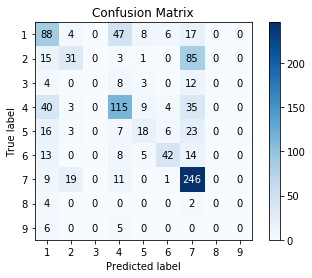

In [98]:
feature_eval(mean_embedded, train_full['Class'].values.ravel())

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Log loss: 1.2612470742015833
Accuracy: 0.5672690763052208


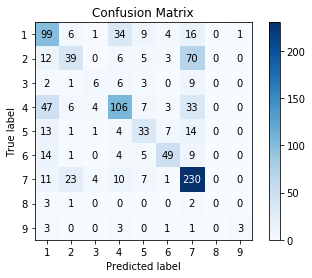

In [99]:
feature_eval(mean_embedded, 
                  train_full['Class'].values.ravel(),
                  XGBClassifier(max_depth=4,
                                objective='multi:softprob',
                                learning_rate=0.03333,
                                )
                 )

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:624: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.286031859324202
Accuracy: 0.5441767068273092


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


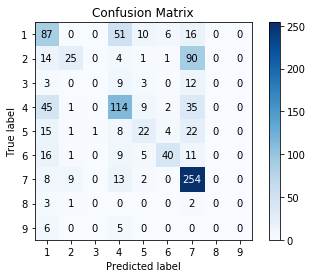

In [101]:
feature_eval(mean_embedded, train_full['Class'].values.ravel(), 
                  SVC(kernel='linear', probability=True))

In [80]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train_full['Text'].values)

In [82]:
# Pad the data 
X = tokenizer.texts_to_sequences(train_full['Text'].values)
X = pad_sequences(X, maxlen=2000)

In [87]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer = regularizers.l2(0.01), activity_regularizer = regularizers.l2(0.01), kernel_constraint = unit_norm(axis=0)))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [89]:
Y = pd.get_dummies(train_full['Class']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(796, 2000) (796, 9)
(200, 2000) (200, 9)


In [90]:
batch_size = 32
model.fit(X_train, Y_train, epochs=8, batch_size=batch_size, validation_split=0.2, callbacks=[ckpt_callback])

Train on 636 samples, validate on 160 samples
Epoch 1/8
636/636 [==============================] - 72s 113ms/step - loss: 11.0270 - categorical_crossentropy: 2.1342 - val_loss: 10.7030 - val_categorical_crossentropy: 2.0177

Epoch 00001: val_loss improved from inf to 10.70301, saving model to keras_model
Epoch 2/8
636/636 [==============================] - 72s 113ms/step - loss: 10.3995 - categorical_crossentropy: 1.9636 - val_loss: 10.1619 - val_categorical_crossentropy: 1.9395

Epoch 00002: val_loss improved from 10.70301 to 10.16187, saving model to keras_model
Epoch 3/8
636/636 [==============================] - 71s 111ms/step - loss: 9.9900 - categorical_crossentropy: 1.8517 - val_loss: 9.9228 - val_categorical_crossentropy: 1.8816

Epoch 00003: val_loss improved from 10.16187 to 9.92277, saving model to keras_model
Epoch 4/8
636/636 [==============================] - 70s 111ms/step - loss: 9.7393 - categorical_crossentropy: 1.6913 - val_loss: 9.7981 - val_categorical_crossentropy

In [91]:
model = load_model('keras_model')

In [92]:
probas = model.predict(X_test)

Log loss: 1.513952563405037
Accuracy: 0.505


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


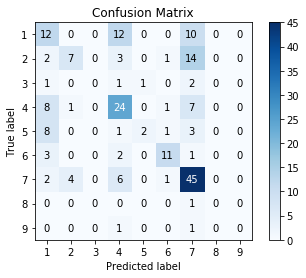

In [93]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)